In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Airports2.csv')

In [95]:
a = df[df['Origin_airport'] == 'YIP']['Seats'].count()
b = df[df['Destination_airport'] == 'YIP']['Seats'].count()
a+b

14460

In [91]:
freq = df['Origin_airport'].value_counts()
unique_fly = freq[freq == 1].index
# df.iloc[unique_fly]['Origin_airport']
freq[freq == max(freq)].index

Index(['ORD'], dtype='object')

In [25]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [29]:
df.shape

(3606803, 15)

In [26]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [31]:
df.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [12]:
df.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

Numero di nodi (aeroporti): 727
Numero di archi (tratte): 36719


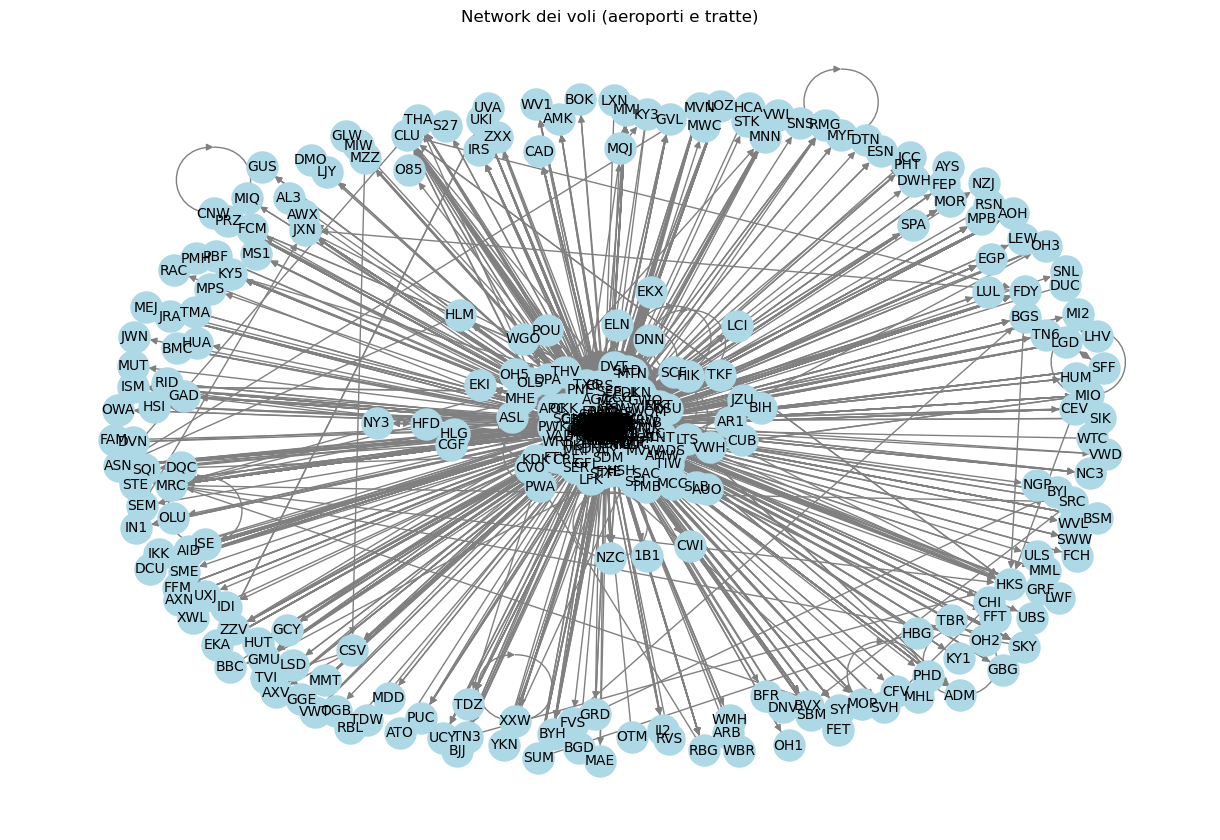

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
G_dir = nx.DiGraph()

origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)

G_dir.add_nodes_from(all_airports)  # Aggiungi tutti gli aeroporti come nodi

# Gli archi rappresentano le tratte (Origin_airport -> Destination_airport)
treated_edges = df.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
for row in treated_edges.itertuples(index=False):
    origin = row.Origin_airport
    destination = row.Destination_airport
    passengers = row.Passengers
    G_dir.add_edge(origin, destination, weight=passengers)  # Aggiungi l'arco con il peso


# 4. Visualizza alcune informazioni sul grafo
print(f"Numero di nodi (aeroporti): {G_dir.number_of_nodes()}")
print(f"Numero di archi (tratte): {G_dir.number_of_edges()}")


# 5. Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_dir, k=0.15)  # Disposizione dei nodi
nx.draw(
    G_dir,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Network dei voli (aeroporti e tratte)")
plt.show()

Numero di nodi (aeroporti): 727
Numero di archi (tratte): 23260


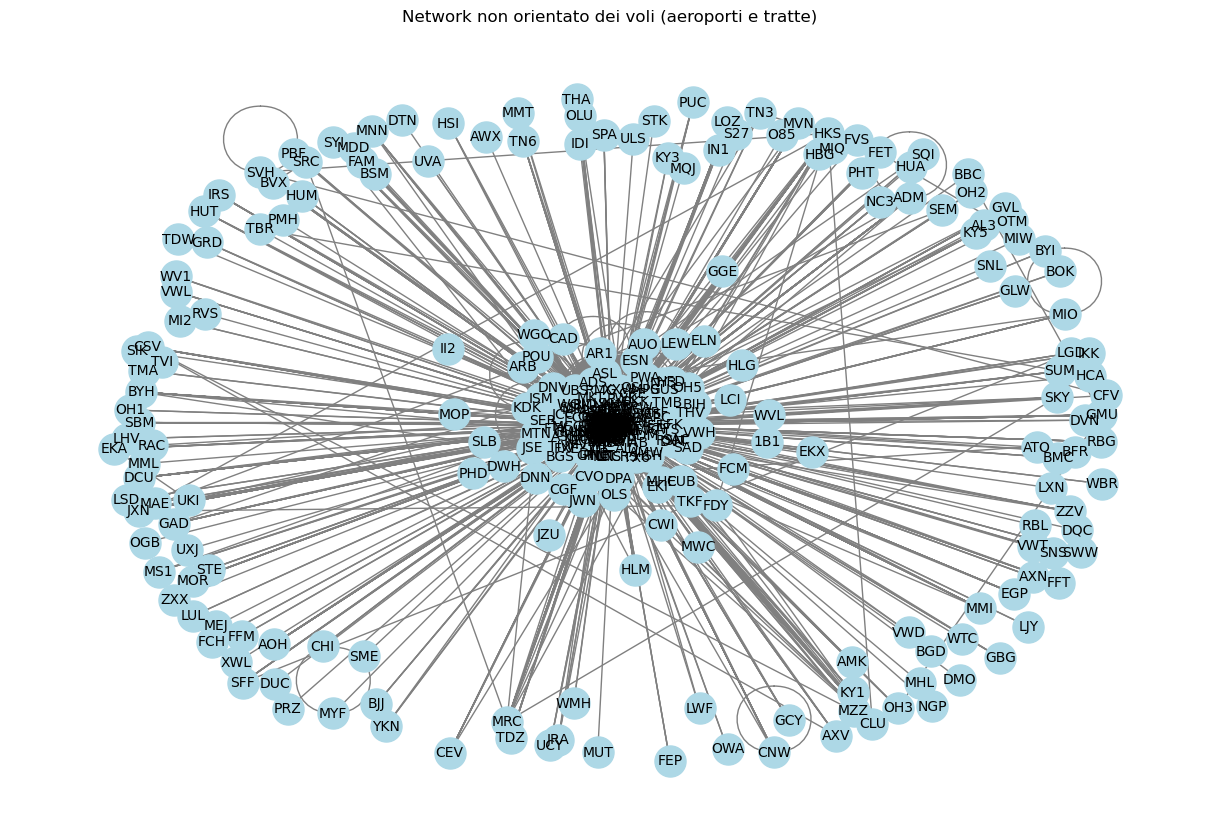

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Crea un grafo non orientato
G_no_dir = nx.Graph()  # Cambiato da DiGraph a Graph

# 2. Raccogli tutti gli aeroporti (nodi)
origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)

G_no_dir.add_nodes_from(all_airports)  # Aggiungi tutti gli aeroporti come nodi

# 3. Calcola i pesi delle tratte (archi)
treated_edges = df.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
for row in treated_edges.itertuples(index=False):
    origin = row.Origin_airport
    destination = row.Destination_airport
    passengers = row.Passengers

    # Se l'arco esiste già, somma i pesi
    if G_no_dir.has_edge(origin, destination):
        G_no_dir[origin][destination]['weight'] += passengers
    else:
        G_no_dir.add_edge(origin, destination, weight=passengers)  # Aggiungi l'arco con il peso

# 4. Visualizza alcune informazioni sul grafo
print(f"Numero di nodi (aeroporti): {G_no_dir.number_of_nodes()}")
print(f"Numero di archi (tratte): {G_no_dir.number_of_edges()}")

# 5. Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_no_dir, k=0.15)  # Disposizione dei nodi
nx.draw(
    G_no_dir,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Network non orientato dei voli (aeroporti e tratte)")
plt.show()

In [17]:
# print(nx.is_connected(G_dir))
print(nx.is_connected(G_no_dir))

True


# 2

In [18]:
from collections import defaultdict, deque

def calculate_betweenness_centrality(graph):
    """
    Calculate the betweenness centrality for all nodes in a graph.
    
    :param graph: Dictionary representing the graph {node: [list_of_neighbors]}.
    :return: Dictionary {node: betweenness_centrality}.
    """
    # Initialize betweenness centrality to zero for all nodes
    betweenness = {node: 0 for node in graph}

    # Iterate through each node in the graph as the source
    for source in graph:
        # Step 1: Find all shortest paths from 'source' using BFS
        stack = []  # Keeps track of the order in which nodes are explored
        paths = defaultdict(list)  # Stores all shortest paths to each node
        paths[source] = [[source]]  # Initial path from the source node to itself
        queue = deque([source])  # BFS queue
        distances = {node: float('inf') for node in graph}  # Distance from source to each node
        distances[source] = 0  # Distance to source itself is zero

        # BFS to calculate shortest paths
        while queue:
            current = queue.popleft()  # Get the next node from the queue
            stack.append(current)  # Add the node to the stack for dependency calculation

            # Explore all neighbors of the current node
            for neighbor in graph[current]:
                # If the neighbor has not been visited, update its distance and add it to the queue
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

                # If the neighbor is at the same shortest distance, add the new paths
                if distances[neighbor] == distances[current] + 1:
                    paths[neighbor].extend([path + [neighbor] for path in paths[current]])

        # Step 2: Compute dependency scores for the nodes
        dependency = {node: 0 for node in graph}

        # Process nodes in reverse order of their exploration
        while stack:
            node = stack.pop()  # Get the node from the stack
            for pred in paths[node]:
                if len(pred) > 1:  # Skip the source node itself
                    parent = pred[-2]  # Get the parent node
                    dependency[parent] += (1 + dependency[node]) / len(paths[node])

            # Update the betweenness centrality for the current node
            if node != source:
                betweenness[node] += dependency[node]

    # Normalize the betweenness centrality for undirected graphs
    normalization = 1 / ((len(graph) - 1) * (len(graph) - 2))
    for node in betweenness:
        betweenness[node] *= normalization

    return betweenness

In [19]:
betweenness_centr = calculate_betweenness_centrality(G_no_dir)

In [20]:
import matplotlib.pyplot as plt

def plot_top_metric(betweenness_centrality, metric, top_n=20):
    """
    Plots the distribution of the top N nodes by betweenness centrality.
    
    :param betweenness_centrality: Dictionary {node: betweenness_centrality}.
    :param top_n: Number of top nodes to include in the histogram.
    """
    # Sort nodes by the metric in descending order
    sorted_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Select the top N nodes
    top_nodes = sorted_centrality[:top_n]
    
    # Extract node names and their centrality values
    nodes = [node for node, centrality in top_nodes]
    centrality_values = [centrality for node, centrality in top_nodes]
    
    # Plot the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(nodes, centrality_values, color='skyblue')
    plt.xlabel("Airports (Nodes)", fontsize=14)
    plt.ylabel(f'{metric}', fontsize=14)
    plt.title(f"Top {top_n} Airports by {metric}", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

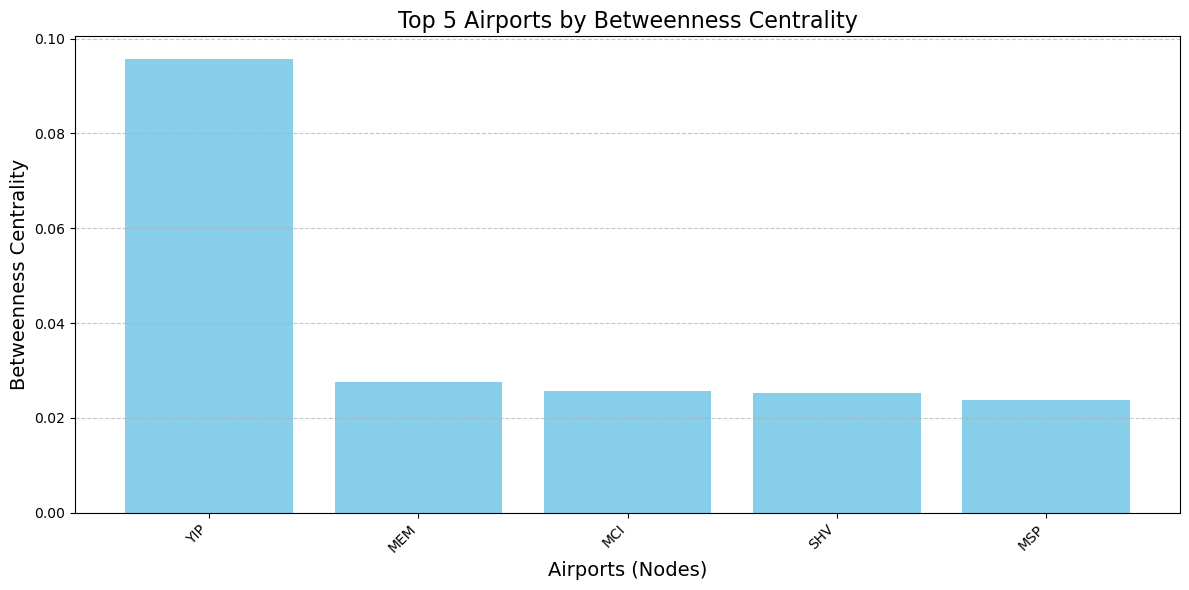

In [21]:
plot_top_metric(betweenness_centr, 'Betweenness Centrality', top_n = 5)

In [22]:
def calculate_closeness_centrality(graph):
    """
    Calculate the closeness centrality for all nodes in a directed graph.
    The distance is measured as the number of hops (shortest paths) to each other node.
    
    :param graph: Dictionary representing the directed graph {node: [list_of_neighbors]}.
    :return: Dictionary {node: closeness_centrality}.
    """
    closeness = {}

    for source in graph:
        # Step 1: Perform BFS to find shortest paths from 'source'
        distances = {node: float('inf') for node in graph}
        distances[source] = 0
        queue = deque([source])

        while queue:
            current = queue.popleft()

            for neighbor in graph[current]:
                # If neighbor hasn't been visited, update its distance and add it to the queue
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        # Step 2: Compute closeness centrality
        reachable_nodes = [dist for dist in distances.values() if dist != float('inf')]
        total_distance = sum(reachable_nodes)

        if total_distance > 0 and len(reachable_nodes) > 2:
            closeness[source] = (len(reachable_nodes) - 1) / total_distance
        else:
            closeness[source] = 0  # Centrality is 0 if the node is isolated or no paths exist

    return closeness

In [31]:
closeness_centrality = calculate_closeness_centrality(G_no_dir)


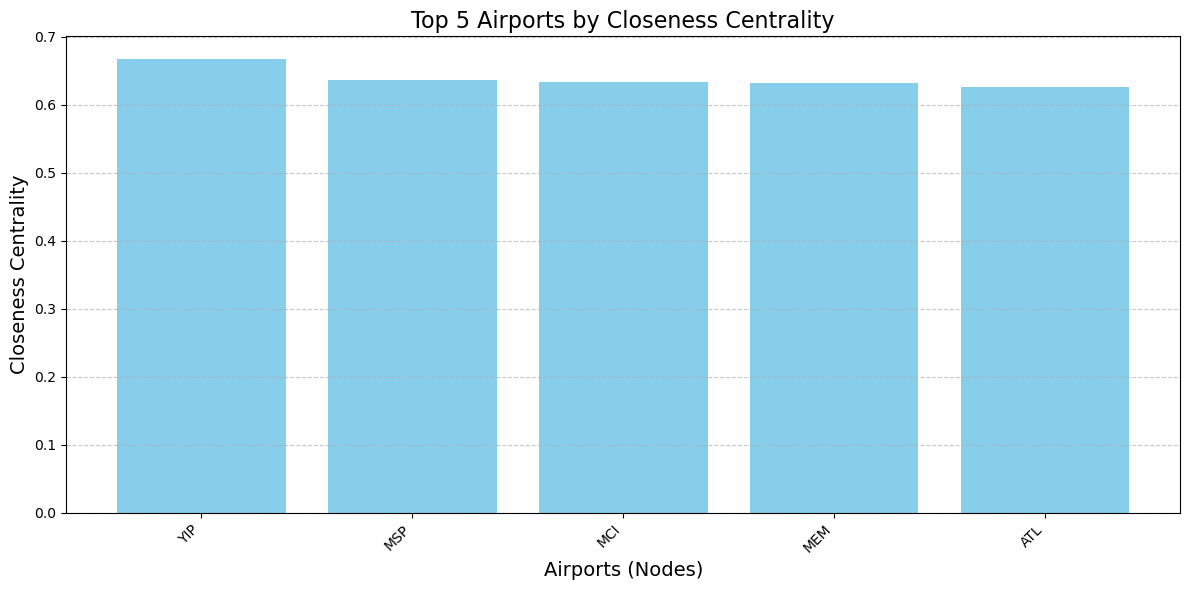

In [32]:
plot_top_metric(closeness_centrality, 'Closeness Centrality', top_n= 5)

In [25]:
def numbers_neighbors(graph):
    """
    Calculate the out-degree (number of outgoing neighbors) for each node in a directed graph.

    :param graph: A directed graph (DiGraph object).
    :return: Dictionary {node: number_of_outgoing_neighbors}.
    """
    neighbors = {}
    for node in graph.nodes: 
        neighbors[node] = len(list(graph.successors(node)))
    
    return neighbors


In [27]:
degree_centrality = numbers_neighbors(G_dir)

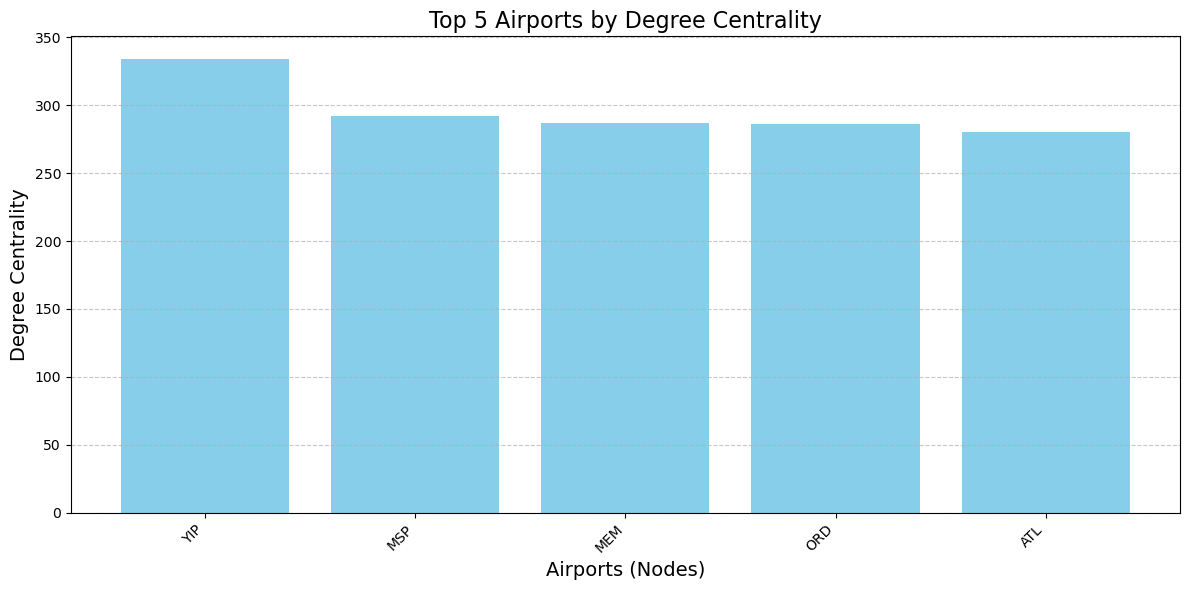

In [28]:
plot_top_metric(degree_centrality, 'Degree Centrality', top_n=5)

I'll use as weights the number of passengers for the moment, i'm not sure it's correct, but for PageRank makes sense, for the other 3 metrics not so much, for this reason i computed them without considering the weights.

In [33]:
def calculate_pagerank(graph, damping=0.85, max_iterations=100, tol=1.0e-6):
    """
    Compute the weighted PageRank of nodes in a directed, weighted graph.

    :param graph: Directed, weighted graph (networkx.DiGraph).
    :param damping: Damping factor (probability of following links, usually 0.85).
    :param max_iterations: Maximum number of iterations.
    :param tol: Tolerance for convergence (difference threshold).
    :return: Dictionary {node: PageRank score}.
    """
    # Initialize PageRank to 1/N for all nodes
    num_nodes = len(graph)
    pagerank = {node: 1 / num_nodes for node in graph}

    # Handle dangling nodes (nodes with no outgoing edges)
    dangling_nodes = {node for node in graph if len(graph[node]) == 0}

    for _ in range(max_iterations):
        new_pagerank = {}
        # Compute the sum of dangling node contributions
        dangling_sum = damping * sum(pagerank[node] for node in dangling_nodes) / num_nodes

        for node in graph:
            # Start with the teleportation factor
            rank_sum = (1 - damping) / num_nodes + dangling_sum

            # Add contributions from neighbors (weighted by edge weights)
            for neighbor in graph.predecessors(node):  # Use predecessors for incoming edges
                weight = graph[neighbor][node].get("weight", 1)  # Get edge weight, default is 1
                total_weight = sum(graph[neighbor][n].get("weight", 1) for n in graph.successors(neighbor))
                if total_weight != 0:
                    rank_sum += damping * (pagerank[neighbor] * weight / total_weight)
                else:
                    pass
            new_pagerank[node] = rank_sum

        # Check for convergence
        diff = sum(abs(new_pagerank[node] - pagerank[node]) for node in graph)
        if diff < tol:
            break

        pagerank = new_pagerank

    return pagerank

In [35]:
pageranks = calculate_pagerank(G_dir)
pageranks

{'SEE': 0.0002191581559049562,
 'VWH': 0.00021777845628755628,
 'AR1': 0.0002177782913126245,
 'AMW': 0.000217910796931973,
 'MIO': 0.00021777815973266786,
 'OSH': 0.00022241651317681286,
 'VCT': 0.00023029207075757303,
 'YIP': 0.0011522295081049893,
 'HUT': 0.00021777815973266786,
 'TKF': 0.00021777815973266786,
 'LJY': 0.00021777815973266786,
 'IN1': 0.00021777815973266786,
 'S27': 0.00021777815973266786,
 'HSV': 0.0007943842955119295,
 'MQT': 0.00036242037113184104,
 'AVL': 0.00047364893791171397,
 'OLM': 0.0002190216786133258,
 'MPS': 0.00021777973197812048,
 'PHL': 0.012247916266672633,
 'OGD': 0.00021870741120884386,
 'ATW': 0.0005190523098735411,
 'FBK': 0.000225733464789047,
 'LRD': 0.0002882418486822407,
 'FET': 0.00021777815973266786,
 'AWX': 0.00021777815973266786,
 'FFT': 0.00021777815973266786,
 'BSM': 0.00021777815973266786,
 'DMO': 0.00021777815973266786,
 'SNL': 0.00021777815973266786,
 'SCE': 0.0005069997410834259,
 'GRR': 0.0011846282962570133,
 'MDW': 0.0076702822151

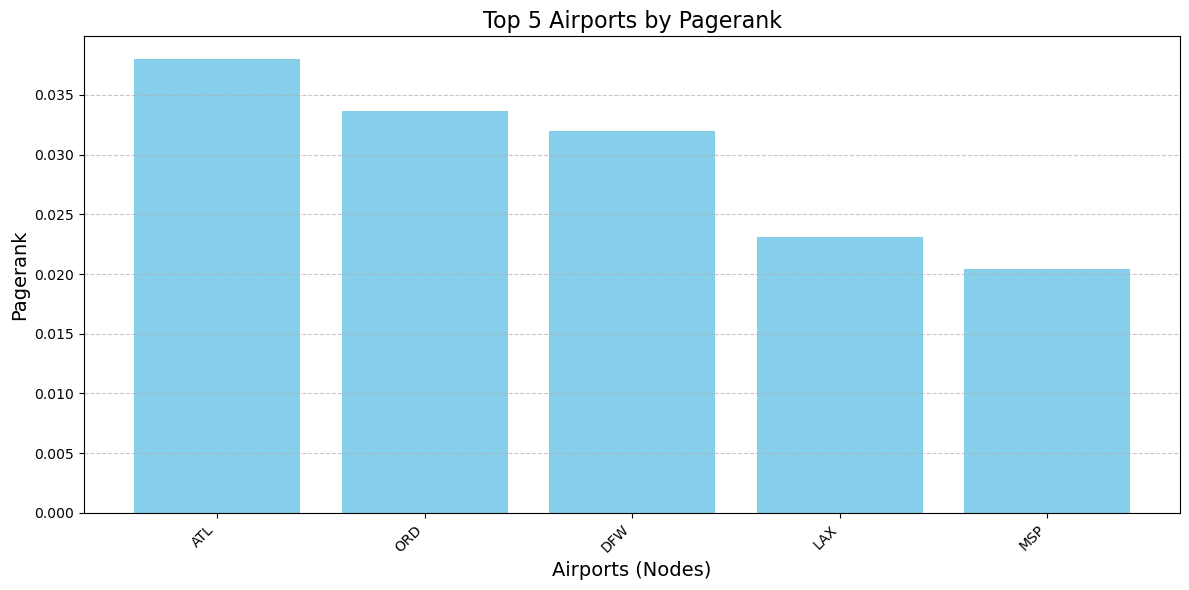

In [36]:
plot_top_metric(pageranks, 'Pagerank', top_n= 5 )

In [17]:
def analyze_centrality(betweenness_centr, closeness_centrality, degree_centrality, pageranks, airport):

    # Calculate centrality metrics
    betweenness = betweenness_centr[airport]
    closeness = closeness_centrality[airport]
    degree = degree_centrality[airport]
    pagerank = pageranks[airport]

    # organize metrics in a dataframe
    centrality_df = pd.DataFrame({
        'Airport': [airport],
        'Betweenness Centrality': [betweenness],
        'Closeness Centrality': [closeness],
        'Degree Centrality': [degree],
        'Pagerank': [pagerank]
    })
    return centrality_df

In [18]:
analyze_centrality(betweenness_centr, closeness_centrality, degree_centrality, pageranks, 'BOS')

,Airport,Betweenness Centrality,Closeness Centrality,Degree Centrality,Pagerank
0,BOS,0.012245,0.583815,228,0.012107


### LLM questions 

Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

#### Here are some alternative centrality measures that might be relevant for analyzing the airport network:

- Eigenvector Centrality:
    Measures how important a node is based on the importance of its neighbors.
    Particularly useful when certain airports are connected to other "high-rank" airports.

- Katz Centrality:
    Similar to Eigenvector Centrality, but assigns decreasing importance to connections further away.
    Useful for capturing the influence of airports that are not directly connected.

- Harmonic Centrality:
    A variation of Closeness Centrality that better handles disconnected graphs by calculating the reciprocal of the distance only for reachable nodes.
    Useful when the network contains isolated sub-networks.

- Flow Centrality:
    Measures how critical a node is in facilitating flows (e.g., passengers or goods) across the network.
    Relevant for analyzing how traffic moves through airports.

- Edge Betweenness Centrality:
    Calculates centrality for edges (connections) rather than nodes.
    Helps identify critical routes that, if removed, would disrupt traffic between regions of the network.

#### How to Check if the Results are Trustworthy

- Compare with Other Studies:
    Look for academic papers or reports related to the analysis of similar networks (transportation, infrastructure, etc.).
    Verify if the suggested measures align with those used in previous studies.

- Intuitive Analysis and Interpretation:
    Each centrality measure should have a clear interpretation in the context of the airport network. For example:
        Eigenvector Centrality should identify airports with highly strategic connections.
        Flow Centrality should highlight airports critical for passenger transit.

- Statistical Validation:
    Apply the new centrality measures to the network and compare the results with already computed ones (Betweenness, Closeness, Degree, PageRank).
    Check for significant correlations or differences:
        Compute correlation coefficients (e.g., Pearson or Spearman) between the centralities.

- Network Experiments:
    Remove nodes or edges with high centrality (according to the new measure) and observe the impact on network connectivity or capacity.
    If significant impacts are observed, it supports the relevance of the measure.

- Consult Domain Experts:
    Seek feedback from experts in airport networks or transportation to evaluate the validity of the suggested measures in a real-world context.

In [21]:
from collections import defaultdict

def calculate_flow_centrality(airport):
    """
    Calcola Flow Centrality per ogni nodo di un grafo.

    Args:
        G (dict): Un dizionario che rappresenta il grafo con nodi come chiavi e una lista di vicini come valori.
                  Es.: {'A': ['B', 'C'], 'B': ['A', 'C'], 'C': ['A', 'B', 'D'], ...}

    Returns:
        dict: Flow Centrality per ogni nodo.
    """
    # Funzione per calcolare i percorsi più brevi tra due nodi
    def shortest_paths(source, target, visited=None):
        if visited is None:
            visited = set()
        visited.add(source)
        if source == target:
            return [[source]]
        paths = []
        for neighbor in airport[source]:
            if neighbor not in visited:
                for path in shortest_paths(neighbor, target, visited.copy()):
                    paths.append([source] + path)
        return paths

    # Calcola Flow Centrality
    flow_centrality = defaultdict(int)
    nodes = list(airport.keys())  # Ottieni tutti i nodi dal grafo
    for source in nodes:
        for target in nodes:
            if source != target:
                paths = shortest_paths(source, target)
                if paths:  # Evita nodi non collegati
                    shortest_path = paths[0]  # Usa il primo percorso più breve trovato
                    for node in shortest_path[1:-1]:  # Escludi nodo iniziale e finale
                        flow_centrality[node] += 1

    return dict(flow_centrality)



# Calcola Flow Centrality per il grafo G
flow_centrality = calculate_flow_centrality(airport)
print("Flow Centrality:", flow_centrality)

NameError: name 'airport' is not defined

# 4

In [27]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

def karger_min_cut(G):
    """
    Implements Karger's Min Cut algorithm using NetworkX graphs
    """
    if len(G.nodes()) < 2:
        return 0, []
    
    # Work with a copy to preserve the original graph
    G_working = G.copy()
    
    # Keep track of which original nodes are merged into each contracted node
    contracted_nodes = {node: {node} for node in G_working.nodes()}
    
    while len(G_working.nodes()) > 2:
        # Choose a random edge
        edges = list(G_working.edges(data=True))
        if not edges:
            return float('inf'), []
        u, v, _ = random.choice(edges)
        
        # Merge the contracted node sets
        contracted_nodes[u].update(contracted_nodes[v])
        del contracted_nodes[v]
        
        # Contract the edge
        for neighbor in list(G_working.neighbors(v)):
            if neighbor != u:
                w = G_working[v][neighbor]['weight']
                if G_working.has_edge(u, neighbor):
                    G_working[u][neighbor]['weight'] += w
                else:
                    G_working.add_edge(u, neighbor, weight=w)
        
        G_working.remove_node(v)
    
    # Find the cut edges from the original graph
    cut_edges = []
    cut_value = 0
    
    if len(G_working.nodes()) != 2:
        return float('inf'), []
    
    partition1, partition2 = contracted_nodes.values()
    
    # Find edges between the two partitions in the original graph
    for u, v, data in G.edges(data=True):
        if ((u in partition1 and v in partition2) or 
            (u in partition2 and v in partition1)):
            weight = data.get('weight', 1)
            cut_edges.append((u, v))
            cut_value += weight
    
    return cut_value, cut_edges

def repeated_karger_min_cut(G, iterations=1000):
    """
    Runs Karger's algorithm multiple times to increase the probability of finding the min cut
    """
    min_cut_value = float('inf')
    best_cut_edges = None
    
    # Using ThreadPoolExecutor to run Karger's algorithm in parallel
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(karger_min_cut, G.copy()) for _ in range(iterations)]
        for future in as_completed(futures):
            cut_value, cut_edges = future.result()
            print(f"Current Cut Value: {cut_value}")
            if cut_value < min_cut_value:
                min_cut_value = cut_value
                best_cut_edges = cut_edges
    
    return min_cut_value, best_cut_edges

def convert_to_dict_format(G):
    """
    Converts a graph into a dictionary format (adjacency list).
    Assumes G is either a dictionary or some other graph structure.
    """
    # If G is already a dictionary, return it as is
    if isinstance(G, dict):
        return G
    
    # Otherwise, we assume it's some graph object (e.g., a networkx graph)
    # and convert it to a dictionary. Let's handle networkx as an example.
    # If you have another graph structure, modify this accordingly.
    try:
        G_dict = {}
        for node in G.nodes():
            G_dict[node] = set(G.neighbors(node))
        return G_dict
    except AttributeError:
        raise ValueError("Unsupported graph structure")
    
def get_subgraphs(cut_edges, G):
    """
    Splits the graph into two subgraphs based on the cut edges without using networkx.
    """
    # Step 1: Remove the cut edges from the graph
    G_temp = {node: set(neighbors) for node, neighbors in G.items()}
    for u, v in cut_edges:
        if v in G_temp.get(u, []):
            G_temp[u].remove(v)
        if u in G_temp.get(v, []):
            G_temp[v].remove(u)

    # Step 2: Use DFS or BFS to find connected components
    def dfs(node, visited, component):
        visited.add(node)
        component.append(node)
        for neighbor in G_temp.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, component)

    visited = set()
    components = []

    for node in G_temp:
        if node not in visited:
            component = []
            dfs(node, visited, component)
            components.append(component)

    # Step 3: Check if there are exactly two components
    if len(components) != 2:
        return None, None

    return components[0], components[1]

def visualize_cut_result(G, cut_edges, subgraph1, subgraph2, min_cut_value):
    """
    Visualizes the graph after the cut with different colors for each subgraph
    """
    G_after_cut = G.copy()
    G_after_cut.remove_edges_from(cut_edges)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_after_cut)
    
    # Draw the base graph
    nx.draw(G_after_cut, pos, with_labels=True, 
            node_color='lightgreen', node_size=2000, 
            font_size=12, font_weight='bold', edge_color='gray')
    
    # Draw the subgraphs with different colors
    if subgraph1 and subgraph2:
        nx.draw_networkx_nodes(G_after_cut, pos, 
                             nodelist=subgraph1, 
                             node_color='lightblue', 
                             node_size=2000)
        nx.draw_networkx_nodes(G_after_cut, pos, 
                             nodelist=subgraph2, 
                             node_color='lightcoral', 
                             node_size=2000)
    
    # Add weight labels to remaining edges
    edge_labels = nx.get_edge_attributes(G_after_cut, 'weight')
    nx.draw_networkx_edge_labels(G_after_cut, pos, edge_labels=edge_labels)
    
    plt.title(f"Flight Network After Cut (Cut Value: {min_cut_value})")
    plt.show()

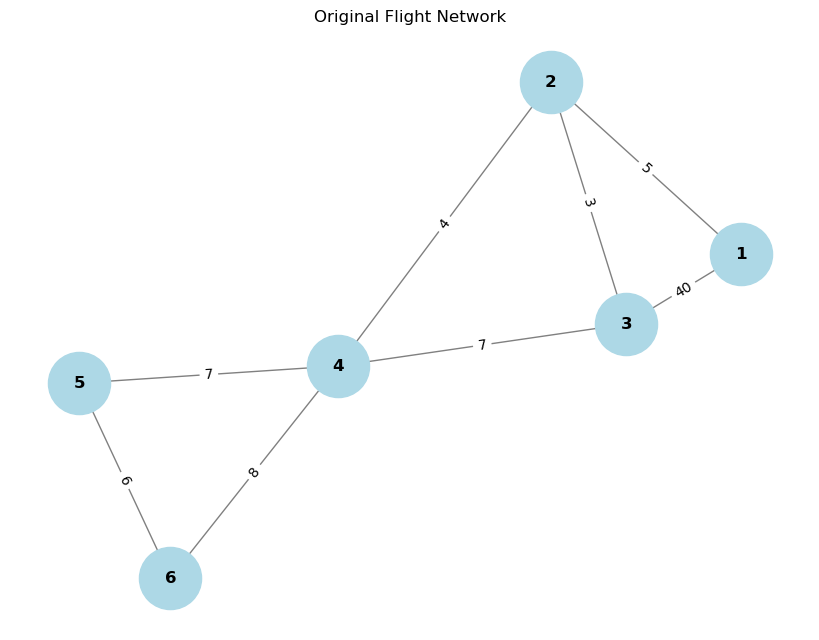

Current Cut Value: 11
Current Cut Value: 11
Current Cut Value: 13
Current Cut Value: 11
Current Cut Value: 11
Current Cut Value: 15
Current Cut Value: 11
Current Cut Value: 11
Current Cut Value: 13
Current Cut Value: 12
Current Cut Value: 45
Current Cut Value: 13
Current Cut Value: 50
Current Cut Value: 15
Current Cut Value: 15
Current Cut Value: 45
Current Cut Value: 15
Current Cut Value: 15
Current Cut Value: 14
Current Cut Value: 12
Current Cut Value: 11
Current Cut Value: 12
Current Cut Value: 14
Current Cut Value: 15
Current Cut Value: 45
Current Cut Value: 11
Current Cut Value: 12
Current Cut Value: 14
Current Cut Value: 45
Current Cut Value: 14
Current Cut Value: 11
Current Cut Value: 50
Current Cut Value: 45
Current Cut Value: 15
Current Cut Value: 15
Current Cut Value: 45
Current Cut Value: 14
Current Cut Value: 13
Current Cut Value: 11
Current Cut Value: 11
Current Cut Value: 45
Current Cut Value: 13
Current Cut Value: 14
Current Cut Value: 15
Current Cut Value: 13
Current Cu

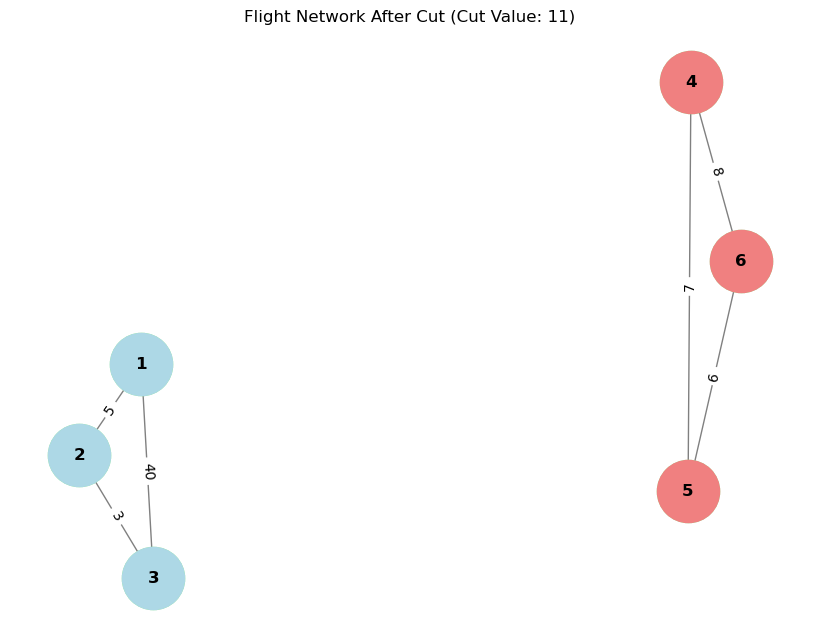

Minimum cut value: 11
Removed flights: [(2, 4), (3, 4)]
First subgraph nodes: [1, 2, 3]
Second subgraph nodes: [4, 5, 6]


In [29]:
def visualize_graph(G, title="Graph"):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=2000, font_size=12, font_weight='bold', edge_color='gray')
    
    # Add weight labels to edges
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title(title)
    plt.show()

def create_test_graph():
    G = nx.Graph()
    
    # Add nodes
    for i in range(1, 7):
        G.add_node(i)
    
    # Add edges with weights
    edges = [
        (1, 2, 5),
        (1, 3, 40),
        (2, 3, 3),
        (2, 4, 4),
        (3, 4, 7),
        (4, 5, 7),
        (5, 6, 6),
        (4, 6, 8)
    ]
    
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    
    return G

# Main execution
if __name__ == "__main__":
    # Create and visualize original graph
    G_test = create_test_graph()

    # Example usage
    visualize_graph(G_test, title="Original Flight Network")


    min_cut_value, cut_edges = repeated_karger_min_cut(G_test, iterations=1000)
    G_test_dict = convert_to_dict_format(G_test)
    # Get subgraphs
    subgraph1, subgraph2 = get_subgraphs(cut_edges, G_test_dict)

    # Visualize results
    visualize_cut_result(G_test, cut_edges, subgraph1, subgraph2, min_cut_value)

    # Print results
    print("Minimum cut value:", min_cut_value)
    print("Removed flights:", cut_edges)
    if subgraph1 and subgraph2:
        print("First subgraph nodes:", sorted(list(subgraph1)))
        print("Second subgraph nodes:", sorted(list(subgraph2)))

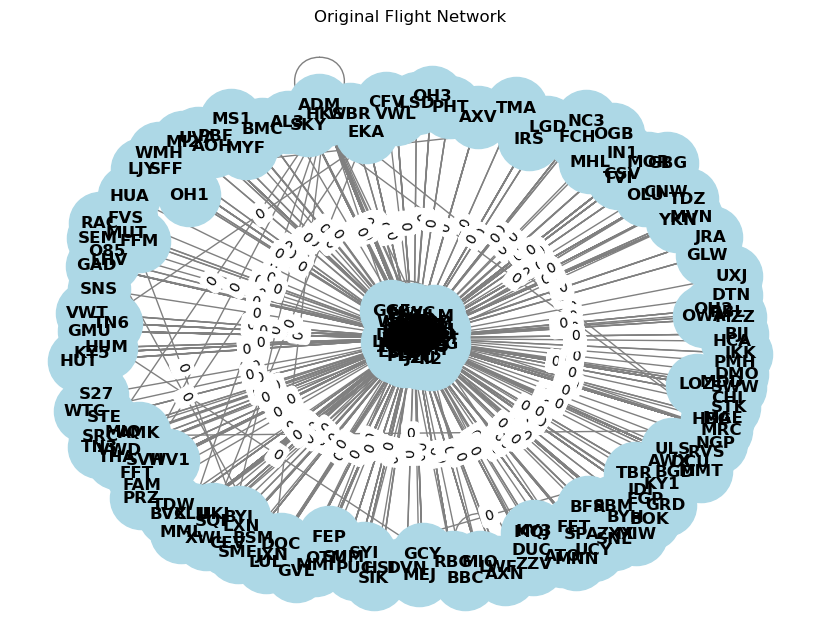

In [ ]:
visualize_graph(G_no_dir, title="Original Flight Network")

min_cut_value, cut_edges = repeated_karger_min_cut(G_no_dir, iterations=1000)

G_no_dir_dict = convert_to_dict_format(G_no_dir)
# Get subgraphs
subgraph1, subgraph2 = get_subgraphs(cut_edges, G_no_dir_dict)
    
# Visualize results
visualize_cut_result(G_no_dir, cut_edges, subgraph1, subgraph2, min_cut_value)

# Print results
print("Minimum cut value:", min_cut_value)
print("Removed flights:", cut_edges)
if subgraph1 and subgraph2:
    print("First subgraph nodes:", sorted(list(subgraph1)))
    print("Second subgraph nodes:", sorted(list(subgraph2)))

In [20]:
import random

def contract_edge(edges, u, v):
    # Rinomina il nodo v in u e aggiorna gli archi
    new_edges = []
    for x, y, weight in edges:
        if x == v:
            x = u
        if y == v:
            y = u
        if x != y:  # Elimina i loop
            new_edges.append((x, y, weight))
    return new_edges

def karger_min_cut(edges, nodes):
    while len(nodes) > 2:
        # Seleziona un arco casuale
        u, v, weight = random.choice(edges)
        
        # Contrai l'arco
        edges = contract_edge(edges, u, v)
        
        # Aggiorna i nodi
        nodes = list(set([x for edge in edges for x in edge[:2]]))  # Ricostruisci i nodi
    
    # Conta il numero di archi rimanenti
    return sum(weight for _, _, weight in edges), edges

def repeated_karger_min_cut(G, iterations=100):
    edges, nodes = convert_graph_to_edges(G)
    min_cut_value = float('inf')
    best_cut = None

    for _ in range(iterations):
        cut_value, cut_edges = karger_min_cut(edges.copy(), nodes.copy())
        if cut_value < min_cut_value:
            min_cut_value = cut_value
            best_cut = cut_edges
    
    return min_cut_value, best_cut

def contract_edge(G, u, v):
    G = G.copy()  # Evita di modificare il grafo originale
    # Unisci i nodi u e v
    for neighbor in list(G.neighbors(v)):
        if neighbor != u:
            G.add_edge(u, neighbor, weight=min(G[u][neighbor]['weight'], G[v][neighbor]['weight']) if G.has_edge(u, neighbor) else G[v][neighbor]['weight'])
    G.remove_node(v)  # Rimuovi il nodo v
    return G

def convert_graph_to_edges(G):
    edges = []
    for u, v, data in G.edges(data=True):
        weight = data['weight']  # Otteniamo il peso dell'arco
        edges.append((u, v, weight))
    return edges, list(G.nodes)

def get_subgraphs(cut_edges, G):
    # Troviamo i nodi nei due sottografi separati
    subgraph1 = set()
    subgraph2 = set()
    for u, v in cut_edges:
        if u not in subgraph1:
            subgraph1.add(u)
        if v not in subgraph1:
            subgraph1.add(v)
        if u not in subgraph2:
            subgraph2.add(u)
        if v not in subgraph2:
            subgraph2.add(v)
    return subgraph1, subgraph2

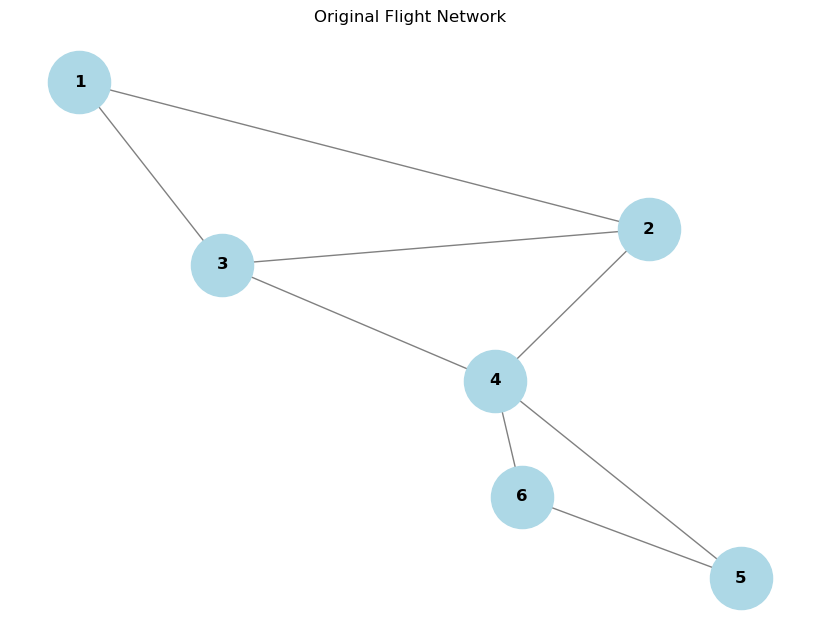

AttributeError: 'list' object has no attribute 'neighbors'

In [21]:
import networkx as nx
def visualize_graph(G, title="Graph"):
    pos = nx.spring_layout(G)  # Layout per la disposizione dei nodi
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', edge_color='gray')
    plt.title(title)
    plt.show()

def create_test_graph():
    # Creiamo un grafo non orientato con pesi per testare l'algoritmo di Stoer-Wagner
    G = nx.Graph()

    # Aggiungiamo i nodi
    for i in range(1, 7):
        G.add_node(i)

    # Aggiungiamo archi con pesi
    edges = [
        (1, 2, 1),  # Arco con peso 5
        (1, 3, 2),  # Arco con peso 2
        (2, 3, 3),  # Arco con peso 1
        (2, 4, 4),  # Arco con peso 3
        (3, 4, 7),  # Arco con peso 4
        (4, 5, 2),  # Arco con peso 2
        (5, 6, 6),  # Arco con peso 3
        (4, 6, 8)   # Arco con peso 6
    ]

    # Aggiungiamo gli archi al grafo
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)

    return G

G_test = create_test_graph()

visualize_graph(G_test, title="Original Flight Network")

min_cut_value, cut_edges = repeated_karger_min_cut(G_test, iterations=1000)

subgraph1, subgraph2 = get_subgraphs(cut_edges, G_test)

G_after_cut = G_test.copy()
G_after_cut.remove_edges_from(cut_edges)

visualize_graph(G_after_cut, title="Flight Network After Cut")

# Evidenziamo i due sottografi separati
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_after_cut)
nx.draw(G_after_cut, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=12, font_weight='bold', edge_color='gray')

# Evidenziamo i nodi dei sottografi separati
nx.draw_networkx_nodes(G_test, pos, nodelist=subgraph1, node_color='lightblue', node_size=2000)
nx.draw_networkx_nodes(G_test, pos, nodelist=subgraph2, node_color='lightcoral', node_size=2000)

# Mostriamo il titolo con il valore del taglio
plt.title(f"Flight Network After Cut (Cut Value: {min_cut_value})")
plt.show()

# Mostriamo il risultato
print("Valore del taglio minimo:", min_cut_value)
print("Nodi nel primo sottografo:", subgraph1)
print("Nodi nel secondo sottografo:", subgraph2)

In [193]:
from collections import deque

# Funzione per aggiungere archi con capacità nel grafo non orientato
def add_edge_with_capacity(graph, u, v, capacity):
    if graph.has_edge(u, v):
        graph[u][v]['capacity'] += capacity
    else:
        graph.add_edge(u, v, capacity=capacity)
    
    # Poiché il grafo è non orientato, dobbiamo aggiungere anche l'arco inverso
    if not graph.has_edge(v, u):
        graph.add_edge(v, u, capacity=capacity)

# Funzione per costruire la rete di livello
def bfs_level(graph, source, sink, level):
    for node in graph.nodes():
        level[node] = -1
    level[source] = 0
    
    queue = deque([source])
    
    while queue:
        u = queue.popleft()
        
        for v in graph.neighbors(u):
            if level[v] == -1 and graph[u][v]['capacity'] > 0:
                level[v] = level[u] + 1
                if v == sink:
                    return True
                queue.append(v)
    
    return False

# Funzione per effettuare un DFS a blocchi
def dfs_block(graph, u, sink, flow, level, start):
    if u == sink:
        return flow
    
    while start[u] < len(graph[u]):
        v = list(graph.neighbors(u))[start[u]]
        if level[v] == level[u] + 1 and graph[u][v]['capacity'] > 0:
            current_flow = min(flow, graph[u][v]['capacity'])
            temp_flow = dfs_block(graph, v, sink, current_flow, level, start)
            if temp_flow > 0:
                graph[u][v]['capacity'] -= temp_flow
                graph[v][u]['capacity'] += temp_flow
                return temp_flow
        start[u] += 1
    
    return 0

# Algoritmo di Dinic per il flusso massimo
def dinic(graph, source, sink):
    max_flow = 0
    level = {}
    
    while bfs_level(graph, source, sink, level):
        start = {node: 0 for node in graph.nodes()}
        while True:
            flow = dfs_block(graph, source, sink, float('Inf'), level, start)
            if flow == 0:
                break
            max_flow += flow
    
    return max_flow

# Funzione per trovare il taglio minimo (approccio semplice)
def find_min_cut(graph, source, sink):
    max_flow = dinic(graph, source, sink)
    
    # Troviamo i nodi raggiungibili dal source nel grafo residuale
    visited = set()
    queue = deque([source])
    visited.add(source)
    
    while queue:
        u = queue.popleft()
        
        for v in graph.neighbors(u):
            if graph[u][v]['capacity'] > 0 and v not in visited:
                visited.add(v)
                queue.append(v)
    
    # Troviamo gli archi che attraversano il taglio minimo
    cut_edges = []
    for u in visited:
        for v in graph.neighbors(u):
            if v not in visited:
                cut_edges.append((u, v))
    
    return max_flow, cut_edges

In [194]:
def create_test_graph():
    G = nx.Graph()  # Grafo non orientato
    edges = [
        (1, 2, 1),
        (1, 3, 2),
        (2, 3, 3),
        (2, 4, 4),
        (3, 4, 7),
        (4, 5, 2),
        (5, 6, 6),
        (4, 6, 8)
    ]
    
    for u, v, w in edges:
        add_edge_with_capacity(G, u, v, w)  # Aggiungiamo gli archi con capacità
    
    return G

# Eseguiamo l'algoritmo su un grafo di esempio
G_test = create_test_graph()
source, sink = 1, 5  # Nodo sorgente e pozzo

max_flow, min_cut_edges = find_min_cut(G_test, source, sink)
print("Flusso massimo:", max_flow)
print("Taglio minimo:", min_cut_edges)

# Visualizzazione del grafo e del taglio minimo
def visualize_min_cut(G, min_cut_edges):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=12, font_weight="bold")

    # Evidenziamo il taglio minimo
    for u, v in min_cut_edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='r', width=2)
    
    plt.title("Graph with Minimum Cut")
    plt.show()

visualize_min_cut(G_test, min_cut_edges)

KeyboardInterrupt: 

# 5

In [10]:
from community import community_louvain

# Identifica le comunità
partition = community_louvain.best_partition(G_no_dir, random_state=42)

# Crea un dizionario con comunità e città
communities = {}
for city, community in partition.items():
    communities.setdefault(community, []).append(city)


In [11]:
communities__ = []
for city, community in partition.items():
    if community not in communities__:
        communities__.append((community))

print(len(communities__))


160


In [12]:
communities

{0: ['SEE', 'MCE', 'VGT', 'VIS', 'BIH', 'SAD', 'DVT'],
 86: ['VWH',
  'AR1',
  'VCT',
  'TKF',
  'LRD',
  'MLU',
  'JAN',
  'SHV',
  'GPT',
  'RUI',
  'DNE',
  'BFM',
  'MTJ',
  'STJ',
  'OFF',
  'ELP',
  'GGG',
  'GRF',
  'SPS',
  'COS',
  'FTW',
  'ACT',
  'CRS',
  'HOB',
  'MGY',
  'GLH',
  'NBG',
  'MSY',
  'EDF',
  'TUP',
  'LIT',
  'TNT',
  'DFW',
  'CRP',
  'SAT',
  'LBB',
  'EFD',
  'PIB',
  'JEF',
  'TUL',
  'BRO',
  'ESF',
  'XNA',
  'SAF',
  'RIV',
  'BIF',
  'LSF',
  'MXF',
  'IAH',
  'PUB',
  'TCL',
  'GWO',
  'OPF',
  'ICT',
  'LWC',
  'ASL',
  'BGS',
  'ROW',
  'PDK',
  'BTR',
  'LFK',
  'LRU',
  'ABQ',
  'AFW',
  'FMN',
  'IAB',
  'SKF',
  'GRK',
  'OCF',
  'HRO',
  'ELD',
  'LCH',
  'NJK',
  'MHE',
  'TYR',
  'JBR',
  'TCM',
  'BPT',
  'MTN',
  'SWO',
  'CVN',
  'FYV',
  'SJT',
  'TX6',
  'TSM',
  'STF',
  'LAW',
  'ARA',
  'LAM',
  'MCF',
  'SVC',
  'AMA',
  'HOT',
  'SVN',
  'CNM',
  'DRT',
  'BHM',
  'OKC',
  'ALM',
  'CLL',
  'POB',
  'MEM',
  'LFT',
  'FSM',
  'SR

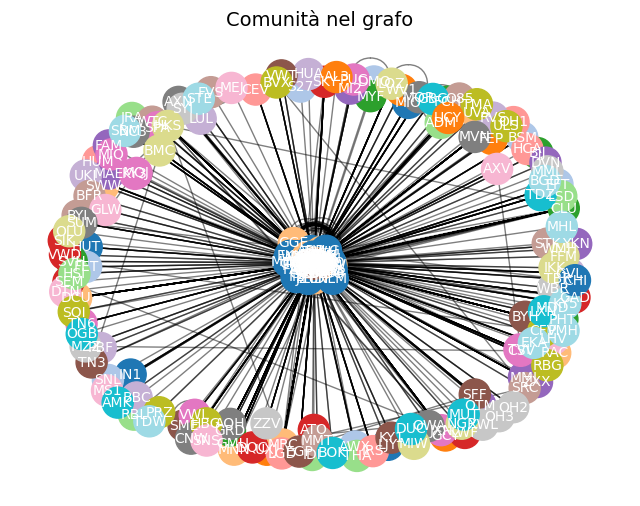

In [13]:
# Ottieni i colori in base alla comunità dalla partition
node_colors = [partition[node] for node in G_no_dir.nodes()]

# Disegna il grafo con le comunità
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_no_dir, seed=42)  # Layout del grafo
nx.draw_networkx_nodes(G_no_dir, pos, node_size=500, node_color=node_colors, cmap=plt.cm.tab20)  # Nodi colorati
nx.draw_networkx_edges(G_no_dir, pos, alpha=0.5)  # Archi
nx.draw_networkx_labels(G_no_dir, pos, font_size=10, font_color="white")  # Etichette

# Titolo e legenda
plt.title("Comunità nel grafo", fontsize=14)
plt.axis("off")  # Nasconde gli assi
plt.show()

In [14]:

def analyze_communities(G, c1, c2):
    """
    Analizza la rete di volo, identifica le comunità e restituisce:
    - Il numero di comunità totali
    - Le città che appartengono a ciascuna comunità
    - Se le città c1 e c2 appartengono alla stessa comunità o meno
    """

   # Identificazione delle comunità usando l'algoritmo Louvain
    partition = community_louvain.best_partition(G, random_state=42)
    
    # Numero di comunità
    num_communities = len(set(partition.values()))
    
    # Identifica le comunità che contengono c1 e c2
    communities_c1 = {comm for city, comm in partition.items() if city == c1}
    communities_c2 = {comm for city, comm in partition.items() if city == c2}
    
    # Determina se c1 e c2 appartengono alla stessa comunità
    same_community = communities_c1 == communities_c2
    
    common_community = list(communities_c1.intersection(communities_c2)) if same_community else None

    # Visualizzazione del grafo con colorazione delle comunità
    pos = nx.spring_layout(G)  # Layout per il grafo
    plt.figure(figsize=(10, 8))

    # Creazione di un elenco di colori per ciascuna comunità
    cmap = plt.cm.get_cmap("tab20", num_communities)  # Usa una tavolozza di colori

    # Disegna il grafo, colorando i nodi per comunità
    nx.draw(G, pos, with_labels=True, node_color=[cmap(partition[node]) for node in G.nodes], node_size=500, font_size=10, font_weight='bold')
    
    # Mostra la visualizzazione del grafo
    plt.title("Flight Network with Communities Highlighted")
    plt.show()

    if common_community:
            # Filtra i nodi che appartengono alla comunità comune
            common_nodes = [node for node, comm in partition.items() if comm == common_community[0]]
            
            # Crea un sottogruppo del grafo con solo i nodi comuni
            G_common = G.subgraph(common_nodes)
            
            # Visualizzazione del grafo con solo i nodi della comunità comune
            plt.figure(figsize=(10, 8))
            nx.draw(G_common, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight='bold')
            plt.title(f"Graph of the Common Community: {common_community[0]}")
            plt.show()

    return {
        "num_communities": num_communities,
        "communities_c1": list(communities_c1),
        "communities_c2": list(communities_c2),
        "same_community": same_community,
        "common_community": common_community
    }

C:\Users\User\AppData\Local\Temp\ipykernel_15448\3792620430.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", num_communities)  # Usa una tavolozza di colori


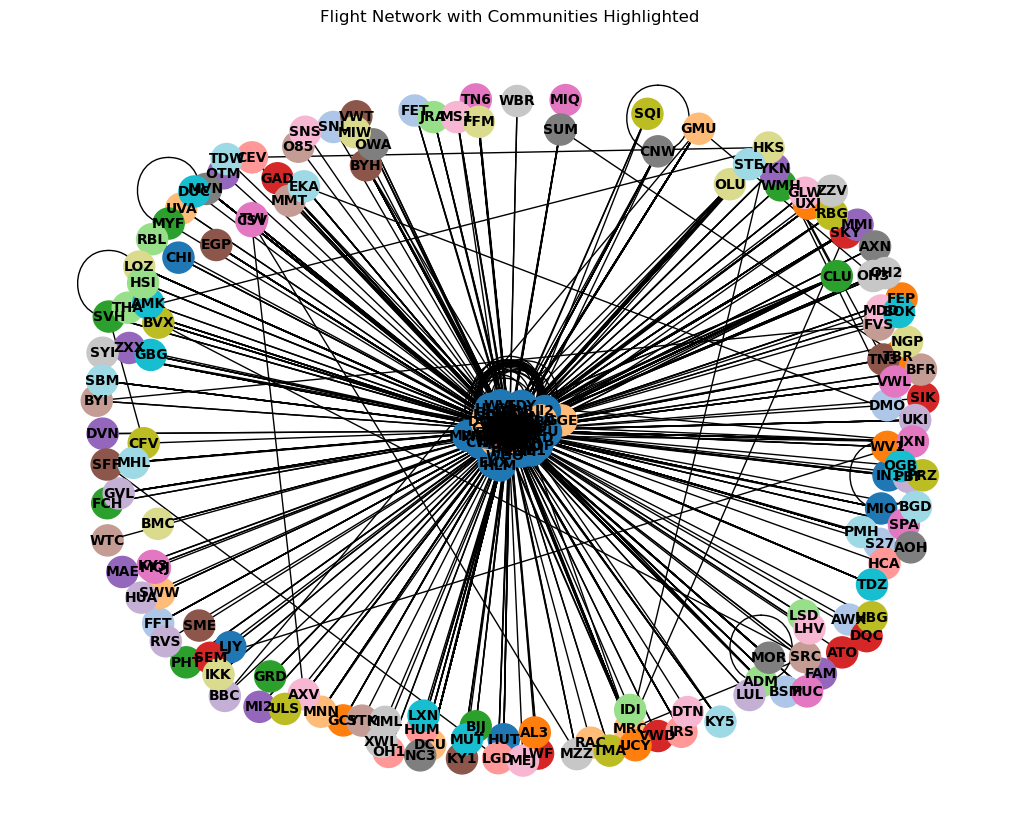

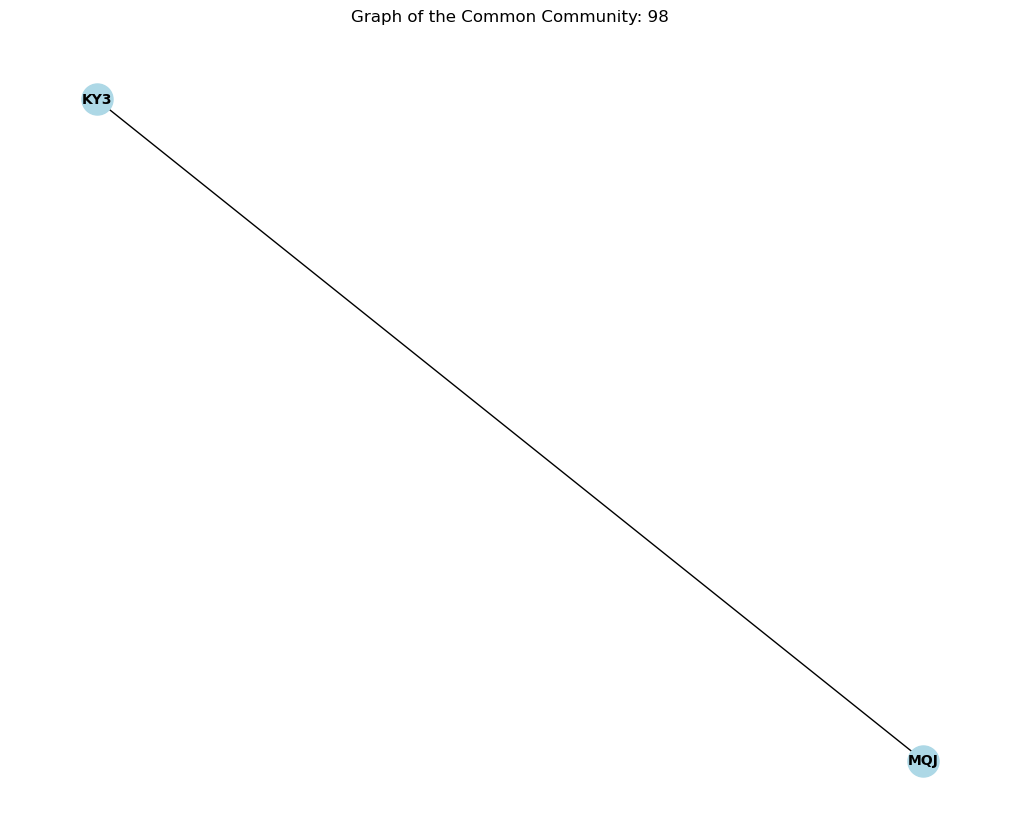

{'num_communities': 160,
 'communities_c1': [98],
 'communities_c2': [98],
 'same_community': True,
 'common_community': [98]}

In [15]:
analyze_communities(G_no_dir, 'MQJ', 'KY3')